# Data Processing
*Author: Paulo Medina*
## Datasets
| Dataset name | Source | Type |
| --- | --- | --- |
| FIRMS Fire Events | NASA - MODIS | Geometry (Point) |
| Paraguay Administrative Boundaries | Paraguayan Statistical Institute | Geometry (Polygon) |
| Protected Areas Boundaries | WPAD | Geometry (Polygon) |
| Human Settlements | Paraguayan Statistical Institute | Geometry (Point) |
| Roads | Paraguayan Statistical Institute | Geometry (Lines) |
| Fire Risk Area | Derived | Geometry (Polygon) |

All data will prepared and limited to the Chaco region.


In [1]:
# Load all necessary libraries
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
# Table names list for PostGIS
tables = []
queries = {}
# Updated Mapping
dtype_mapping = {
    'int64': 'INTEGER',
    'int32': 'INTEGER',
    'float64': 'DOUBLE PRECISION', # Better than DECIMAL for scientific/GIS data
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT' # Use TEXT in Postgres instead of VARCHAR(255) to avoid truncation
}

def generate_sql_schema(gdf, table_name):
    srid = 32720
    table = table_name.replace('_', ' ').title()
    sql = f"\n-- {table}\nCREATE TABLE {table_name} (\n    {table_name}_id SERIAL PRIMARY KEY,\n"
    tables.append(table_name)
    
    has_geometry = False
    
    for col, dtype in gdf.dtypes.items():
        if col == 'geometry':
            has_geometry = True
            raw_geom_type = str(gdf.geometry.geom_type.unique()[0]).upper()
            sql_dtype = f"GEOMETRY({raw_geom_type}, {srid})"
        else:
            sql_dtype = dtype_mapping.get(str(dtype), 'TEXT')
            
        sql += f"    {col} {sql_dtype},\n"
    
    sql = sql.rstrip(',\n') + "\n);\n"
    
    # Add spatial index if geometry exists
    if has_geometry:
        sql += f"CREATE INDEX idx_{table_name}_geom ON {table_name} USING GIST(geometry);\n"
    
    queries[table_name] = sql
    return sql

In [3]:
# Display first 5 rows of the GeoDataFrame and get length of data
def display_gdf_info(gdf, name):
    print(f"Length of {name} GeoDataFrame: {len(gdf)}")
    print(f"\nData types in {name} GeoDataFrame:")
    print(gdf.dtypes)
    print(gdf.head(5))
    gdf.plot()

### Chaco Region Administrative Boundaries

All geographic data will be clipped to these boundaries.

Length of Paraguay Boundaries GeoDataFrame: 17

Data types in Paraguay Boundaries GeoDataFrame:
ADM0_CODE        int64
ADM0_NAME       object
ADM1_CODE        int64
ADM1_NAME       object
DISP_AREA       object
EXP1_YEAR        int64
STATUS          object
STR1_YEAR        int64
Shape_Area     float64
Shape_Leng     float64
geometry      geometry
dtype: object
   ADM0_CODE ADM0_NAME  ADM1_CODE      ADM1_NAME DISP_AREA  EXP1_YEAR  \
0        194  Paraguay       2311  Alto Paraguay        NO       3000   
1        194  Paraguay       2312    Alto Parana        NO       3000   
2        194  Paraguay       2313        Amambay        NO       3000   
3        194  Paraguay       2314       Boqueron        NO       3000   
4        194  Paraguay       2315       Caaguazu        NO       3000   

         STATUS  STR1_YEAR  Shape_Area  Shape_Leng  \
0  Member State       1000    6.785640   13.908306   
1  Member State       1000    1.264466    7.937863   
2  Member State       1000    1.1147

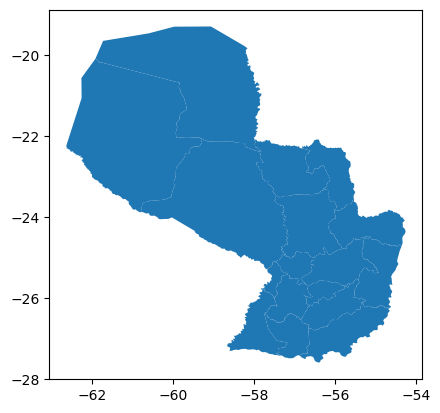

In [4]:
# Ingest data
# Convert to GeoDataFrame
pry_boundaries_gdf = gpd.read_file('raw/boundaries/Paraguay_bnd.shp')
pry_boundaries_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(pry_boundaries_gdf, "Paraguay Boundaries")

<Axes: >

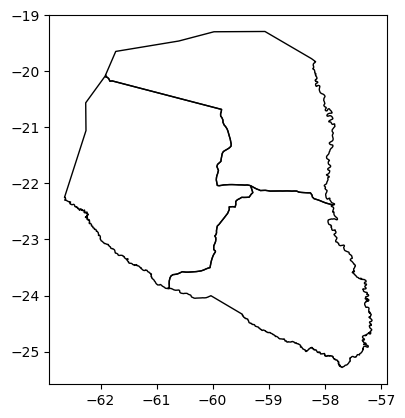

In [5]:
# Mask to get only Chaco region
chaco_mask = pry_boundaries_gdf['ADM1_NAME'].apply(lambda x: x in ['Alto Paraguay', 'Boqueron', 'Presidente Hayes'])
# Extract data by mask
chaco_boundaries = pry_boundaries_gdf[chaco_mask].copy()
del(pry_boundaries_gdf) # Remove full dataset

chaco_boundaries.plot(edgecolor='black', facecolor='none')

In [6]:
# Clean data
# Remove unused columns
chaco_boundaries.drop(columns=['ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP1_YEAR', 'STATUS', 'STR1_YEAR'], inplace=True)

# Calculate area in square kilometers
chaco_boundaries['area_km2'] = chaco_boundaries.geometry.to_crs(epsg=32720).area / 10**6

chaco_boundaries = chaco_boundaries[['ADM1_CODE','ADM1_NAME', 'area_km2', 'geometry']]

In [7]:
chaco_boundaries_query = generate_sql_schema(chaco_boundaries, 'chaco_boundaries')
print(chaco_boundaries_query)


-- Chaco Boundaries
CREATE TABLE chaco_boundaries (
    chaco_boundaries_id SERIAL PRIMARY KEY,
    ADM1_CODE INTEGER,
    ADM1_NAME TEXT,
    area_km2 DOUBLE PRECISION,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_chaco_boundaries_geom ON chaco_boundaries USING GIST(geometry);



### Load and clip all layers to the Chaco

In [8]:
# Function to clip features to Chaco region
def clip_to_chaco(gdf):
    gdf_clipped = gpd.clip(gdf, chaco_boundaries)
    return gdf_clipped

### Admin 2 level boundaries

Length of Chaco Districts GeoDataFrame: 21

Data types in Chaco Districts GeoDataFrame:
ADM0_ES         object
ADM0_PCODE      object
ADM1_ES         object
ADM1_PCODE      object
ADM2_ES         object
ADM2_PCODE      object
geometry      geometry
dtype: object
      ADM0_ES ADM0_PCODE           ADM1_ES ADM1_PCODE  \
234  Paraguay         PY  PRESIDENTE HAYES       PY15   
235  Paraguay         PY  PRESIDENTE HAYES       PY15   
231  Paraguay         PY  PRESIDENTE HAYES       PY15   
238  Paraguay         PY  PRESIDENTE HAYES       PY15   
233  Paraguay         PY  PRESIDENTE HAYES       PY15   

                        ADM2_ES ADM2_PCODE  \
234                      NANAWA     PY1505   
235                 JOSÉ FALCÓN     PY1506   
231             BENJAMÍN ACEVAL     PY1502   
238  GENERAL JOSÉ MARÍA BRUGUEZ     PY1509   
233                 VILLA HAYES     PY1504   

                                              geometry  
234  MULTIPOLYGON (((-57.707 -25.27, -57.707 -25.27...  
235

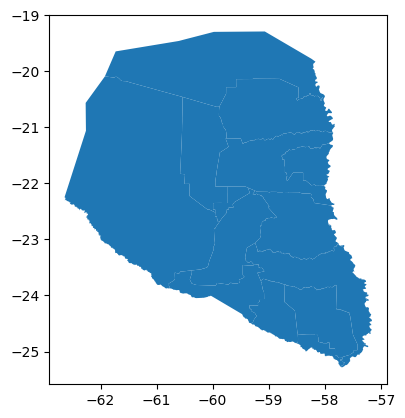

In [9]:
# Ingest data
# Convert to GeoDataFrame
pry_districts_gdf = gpd.read_file('raw/boundaries/pry_admbnda_adm2_DGEEC_2020.shp')
pry_districts_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Remove unused columns
# pry_districts_gdf.drop(columns=['fid','DPTO','DISTRITO', 'DPTO_DESC','AREA','DIST_DESC', 'RODA_VIA', 'Long_Metro'], inplace=True)
#Clip to Chaco region
chaco_districts = clip_to_chaco(pry_districts_gdf.copy())

del(pry_districts_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_districts, "Chaco Districts")

In [10]:
chaco_districts_query = generate_sql_schema(chaco_districts, 'chaco_districts')
print(chaco_districts_query)


-- Chaco Districts
CREATE TABLE chaco_districts (
    chaco_districts_id SERIAL PRIMARY KEY,
    ADM0_ES TEXT,
    ADM0_PCODE TEXT,
    ADM1_ES TEXT,
    ADM1_PCODE TEXT,
    ADM2_ES TEXT,
    ADM2_PCODE TEXT,
    geometry GEOMETRY(MULTIPOLYGON, 32720)
);
CREATE INDEX idx_chaco_districts_geom ON chaco_districts USING GIST(geometry);



### FIRMS Fire Data

Length of Fire Events GeoDataFrame: 2612

Data types in Fire Events GeoDataFrame:
latitude       float64
longitude      float64
acq_date        object
bright_t31     float64
brightness     float64
confidence       int64
track          float64
instrument      object
scan           float64
satellite       object
geometry      geometry
dtype: object
      latitude  longitude    acq_date  bright_t31  brightness  confidence  \
2803 -24.90294  -58.33410  2025-09-06      289.90      304.58          30   
4582 -24.79166  -58.67841  2025-09-26      303.92      316.84          62   
4581 -24.79015  -58.66854  2025-09-26      303.89      316.98          62   
4580 -24.78693  -58.58777  2025-09-26      307.19      362.35         100   
4579 -24.78541  -58.57786  2025-09-26      303.79      328.06          80   

      track instrument  scan satellite                 geometry  
2803   1.24      MODIS  1.58      Aqua  POINT (-58.334 -24.903)  
4582   1.01      MODIS  1.02      Aqua  POINT (-58.678 -

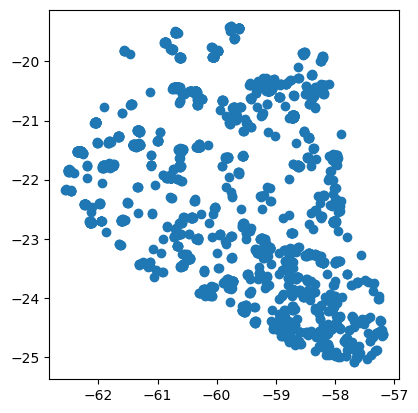

In [11]:
# Ingest data
fire_events_df = pd.read_json('raw/fire_events/fire_nrt_M-C61_676512.json') # Read JSON file into a standard DataFrame

# Convert to GeoDataFrame
fire_events_gdf = gpd.GeoDataFrame( 
    fire_events_df, geometry=gpd.points_from_xy(fire_events_df.longitude, fire_events_df.latitude))
fire_events_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)
fire_events_gdf = clip_to_chaco(fire_events_gdf)
# Remove standard DataFrame to free up memory
del(fire_events_df)

# Clean data
# Remove rows with null geometry
fire_events_gdf = fire_events_gdf[fire_events_gdf.geometry.notnull()]
# Remove unused columns
fire_events_gdf.drop(columns=['version', 'daynight', 'frp', 'acq_time'], inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(fire_events_gdf, "Fire Events")

In [12]:
fire_events_query = generate_sql_schema(fire_events_gdf, 'fire_events')
print(fire_events_query)


-- Fire Events
CREATE TABLE fire_events (
    fire_events_id SERIAL PRIMARY KEY,
    latitude DOUBLE PRECISION,
    longitude DOUBLE PRECISION,
    acq_date TEXT,
    bright_t31 DOUBLE PRECISION,
    brightness DOUBLE PRECISION,
    confidence INTEGER,
    track DOUBLE PRECISION,
    instrument TEXT,
    scan DOUBLE PRECISION,
    satellite TEXT,
    geometry GEOMETRY(POINT, 32720)
);
CREATE INDEX idx_fire_events_geom ON fire_events USING GIST(geometry);



### Roads

Length of Chaco Roads GeoDataFrame: 22547

Data types in Chaco Roads GeoDataFrame:
NOMBRE          object
TIPO_VIA        object
DesTipoVia      object
DesRodaVia      object
geometry      geometry
dtype: object
      NOMBRE TIPO_VIA    DesTipoVia DesRodaVia  \
75961   None        7  Camino Rural     Tierra   
75923   None        7  Camino Rural     Tierra   
75025   None        7  Camino Rural     Tierra   
74835   None        7  Camino Rural     Tierra   
75790   None        7  Camino Rural     Tierra   

                                                geometry  
75961  LINESTRING (-58.615 -24.787, -58.618 -24.79, -...  
75923  LINESTRING (-58.477 -24.827, -58.478 -24.827, ...  
75025  LINESTRING (-58.477 -24.827, -58.478 -24.827, ...  
74835  LINESTRING (-58.372 -24.799, -58.371 -24.798, ...  
75790  LINESTRING (-58.681 -24.798, -58.681 -24.798, ...  


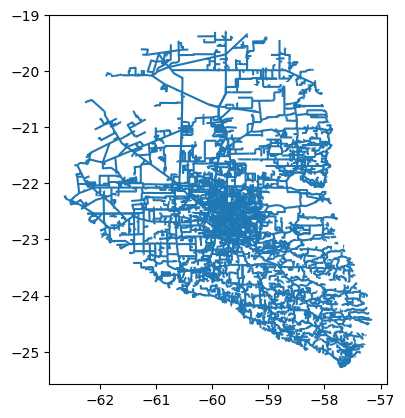

In [13]:
# Ingest data
# Convert to GeoDataFrame
pry_roads_gdf = gpd.read_file('raw/Vias/V_as_Paraguay_INE_20221.shp')
pry_roads_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Remove unused columns
pry_roads_gdf.drop(columns=['fid','DPTO','DISTRITO', 'DPTO_DESC','AREA','DIST_DESC', 'RODA_VIA', 'Long_Metro'], inplace=True)

#Clip to Chaco region
chaco_roads = clip_to_chaco(pry_roads_gdf.copy())

del(pry_roads_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_roads, "Chaco Roads")

In [14]:
chaco_roads_query = generate_sql_schema(chaco_roads, 'chaco_roads')
print(chaco_roads_query)


-- Chaco Roads
CREATE TABLE chaco_roads (
    chaco_roads_id SERIAL PRIMARY KEY,
    NOMBRE TEXT,
    TIPO_VIA TEXT,
    DesTipoVia TEXT,
    DesRodaVia TEXT,
    geometry GEOMETRY(LINESTRING, 32720)
);
CREATE INDEX idx_chaco_roads_geom ON chaco_roads USING GIST(geometry);



### Water bodies

Length of Chaco Rivers GeoDataFrame: 523

Data types in Chaco Rivers GeoDataFrame:
NOMBRE        object
geometry    geometry
dtype: object
              NOMBRE                                           geometry
22294  Rio Pilcomayo  MULTILINESTRING ((-57.718 -25.267, -57.718 -25...
5474    Rio Paraguay  LINESTRING (-57.68 -25.276, -57.68 -25.276, -5...
5487   Rio Pilcomayo  LINESTRING (-57.686 -25.281, -57.686 -25.281, ...
5492            None  LINESTRING (-57.687 -25.281, -57.687 -25.281, ...
5413   Rio Pilcomayo  MULTILINESTRING ((-57.687 -25.281, -57.687 -25...


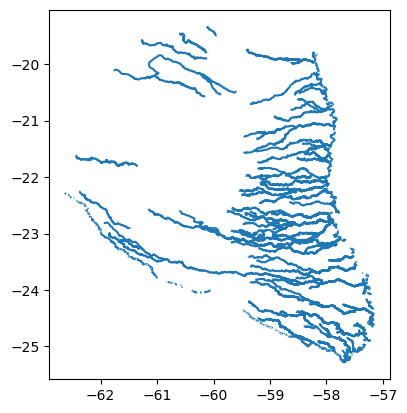

In [15]:
# Ingest data
# Convert to GeoDataFrame
pry_rivers_gdf = gpd.read_file('raw/Hidrografia/Hidrografia.shp')
pry_rivers_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Clip to Chaco region
chaco_rivers = clip_to_chaco(pry_rivers_gdf.copy())
del(pry_rivers_gdf) # Remove full dataset

# Remove unused columns
chaco_rivers.drop(columns=['fid'], inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_rivers, "Chaco Rivers")

In [16]:
chaco_rivers_query = generate_sql_schema(chaco_rivers, 'chaco_rivers')
print(chaco_rivers_query)


-- Chaco Rivers
CREATE TABLE chaco_rivers (
    chaco_rivers_id SERIAL PRIMARY KEY,
    NOMBRE TEXT,
    geometry GEOMETRY(MULTILINESTRING, 32720)
);
CREATE INDEX idx_chaco_rivers_geom ON chaco_rivers USING GIST(geometry);



### Protected Areas

<Axes: >

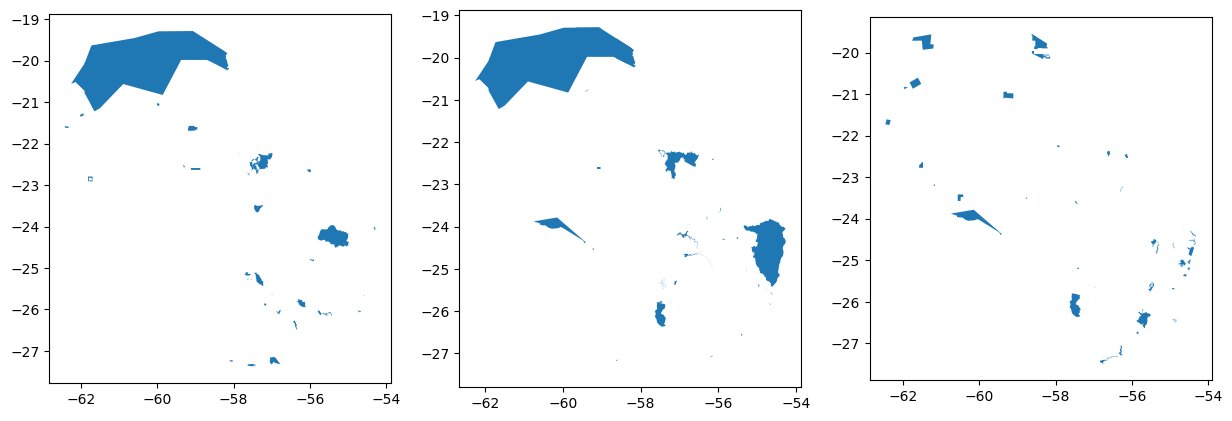

In [17]:
# Data obtained from: https://www.protectedplanet.net/country/PRY
pry_wpda_gdf_1 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_0/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')
pry_wpda_gdf_2 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_1/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')
pry_wpda_gdf_3 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_2/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

pry_wpda_gdf_1.plot(ax=ax[0])
pry_wpda_gdf_2.plot(ax=ax[1])
pry_wpda_gdf_3.plot(ax=ax[2])

Length of Chaco Protected Areas GeoDataFrame: 31

Data types in Chaco Protected Areas GeoDataFrame:
NAME_ENG        object
NAME            object
DESIG           object
DESIG_ENG       object
DESIG_TYPE      object
IUCN_CAT        object
INT_CRIT        object
REALM           object
REP_M_AREA     float64
REP_AREA       float64
GIS_AREA       float64
NO_TAKE         object
NO_TK_AREA     float64
GOV_TYPE        object
GOVSUBTYPE      object
OWN_TYPE        object
OWNSUBTYPE      object
MANG_AUTH       object
ISO3            object
SUPP_INFO       object
CONS_OBJ        object
geometry      geometry
dtype: object
                    NAME_ENG                     NAME              DESIG  \
88                 Toldo Cue                Toldo Cue    Reserva Natural   
71                 Tinfunque                Tinfunque  Sitio Ramsar 1995   
94   Coronel Valóis Rivarola  Coronel Valóis Rivarola    Reserva Natural   
131               Toro Mocho               Toro Mocho    Reserva Privada   


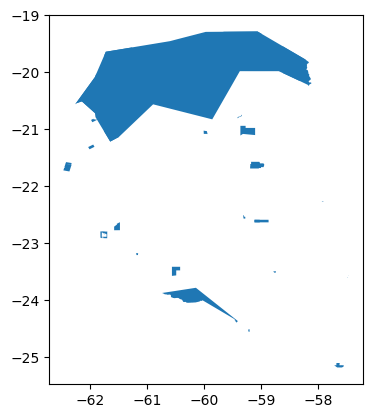

In [18]:
# Append all three GeoDataFrames
pry_wpda_gdf = pd.concat([pry_wpda_gdf_1, pry_wpda_gdf_2, pry_wpda_gdf_3], ignore_index=True)

# Remove duplicates based on 'WDPAID'
pry_wpda_gdf.drop_duplicates(subset=['NAME_ENG'], inplace=True)
pry_wpda_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Remove unused columns
pry_wpda_gdf.drop(columns=['SITE_ID', 'SITE_PID', 'SITE_TYPE', 'MANG_PLAN', 'METADATAID', 'PRNT_ISO3', 'INLND_WTRS', 'OECM_ASMT', 'GIS_M_AREA', 'STATUS_YR', 'STATUS', 'VERIF'], inplace=True)

# Clip to Chaco region
chaco_protected_areas = clip_to_chaco(pry_wpda_gdf.copy())
del(pry_wpda_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_protected_areas, "Chaco Protected Areas")

In [19]:
chaco_protected_areas_query = generate_sql_schema(chaco_protected_areas, 'chaco_protected_areas')
print(chaco_protected_areas_query)


-- Chaco Protected Areas
CREATE TABLE chaco_protected_areas (
    chaco_protected_areas_id SERIAL PRIMARY KEY,
    NAME_ENG TEXT,
    NAME TEXT,
    DESIG TEXT,
    DESIG_ENG TEXT,
    DESIG_TYPE TEXT,
    IUCN_CAT TEXT,
    INT_CRIT TEXT,
    REALM TEXT,
    REP_M_AREA DOUBLE PRECISION,
    REP_AREA DOUBLE PRECISION,
    GIS_AREA DOUBLE PRECISION,
    NO_TAKE TEXT,
    NO_TK_AREA DOUBLE PRECISION,
    GOV_TYPE TEXT,
    GOVSUBTYPE TEXT,
    OWN_TYPE TEXT,
    OWNSUBTYPE TEXT,
    MANG_AUTH TEXT,
    ISO3 TEXT,
    SUPP_INFO TEXT,
    CONS_OBJ TEXT,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_chaco_protected_areas_geom ON chaco_protected_areas USING GIST(geometry);



### Risk Surface

Length of Risk Surface GeoDataFrame: 5933

Data types in Risk Surface GeoDataFrame:
id              object
count            int32
risk_level       int32
geometry      geometry
dtype: object
            id  count  risk_level  \
0  +1075+15080      2           2   
1  +1076+15069      3           2   
2  +1110+15169      3           2   
3  +1111+15080     10           2   
4  +1111+15102      1           2   

                                            geometry  
0  POLYGON ((-62.641 -22.241, -62.641 -22.245, -6...  
1  POLYGON ((-62.636 -22.29, -62.636 -22.299, -62...  
2  MULTIPOLYGON (((-62.463 -21.843, -62.463 -21.8...  
3  POLYGON ((-62.471 -22.249, -62.471 -22.254, -6...  
4  POLYGON ((-62.462 -22.141, -62.462 -22.145, -6...  


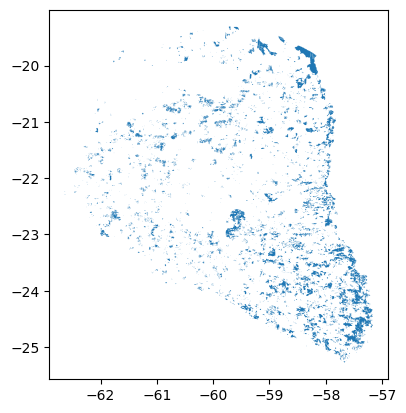

In [20]:
# Load risk surface
risk_surface_gdf = gpd.read_file('raw/Risk/Chaco_Wildfire_Risk.geojson')
risk_surface_gdf.set_crs(epsg=32720, inplace=True, allow_override=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(risk_surface_gdf, "Risk Surface")

In [21]:
risk_surface_gdf_query = generate_sql_schema(risk_surface_gdf, 'risk_surface')
print(risk_surface_gdf_query)


-- Risk Surface
CREATE TABLE risk_surface (
    risk_surface_id SERIAL PRIMARY KEY,
    id TEXT,
    count INTEGER,
    risk_level INTEGER,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_risk_surface_geom ON risk_surface USING GIST(geometry);



## Add table creation queries to `.sql` file

In [22]:
# Edit .sql file and add queries for each table
with open(r'../database/01_schema.sql', 'a') as file:
    for table_name, query in queries.items():
        file.write(query)
        file.write('\n')